# Evaluation Pipeline - All Objects

This notebook evaluates the trained models (RGB and RGBD) on **ALL** LineMOD objects.

Features:
- RGB Pipeline: Full 6D pose (rotation + translation) evaluation for all objects
- RGBD Pipeline: DenseFusion, PVN3D, FFB6D, Residual Learning evaluation for all objects
- YOLO Detection IoU evaluation for all objects
- Summary tables and visualizations comparing all objects

In [58]:
import os
import sys
import platform
import importlib
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns

# Add project root to path
project_root = os.path.dirname(os.getcwd())
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Force reload utils.dataset to pick up RGB->BGR fix
import utils.dataset
importlib.reload(utils.dataset)

# Imports (after reload)
from rgb_pipeline.config import ConfigRGB, ConfigInference
from rgb_pipeline.model import RGBPoseEstimator
from rgb_pipeline.train import compute_pinhole_translations
from rgbd_pipelines import create_model, list_models
from rgbd_pipelines.evaluate import evaluate_model as evaluate_rgbd_model
from utils.dataset import LineMODDataset, linemod_collate_fn, rgbd_collate_fn
from utils.geometry import quaternion_to_rotation_matrix
from utils.metrics import average_distance_metric
from utils import load_ply_vertices

print(f"Platform: {platform.system()} {platform.release()}")
print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
print("[OK] utils.dataset reloaded with RGB->BGR fix")

Platform: Linux 6.6.87.2-microsoft-standard-WSL2
PyTorch: 2.9.1+cu128
CUDA available: True
CUDA device: NVIDIA GeForce RTX 5070
[OK] utils.dataset reloaded with RGB->BGR fix


In [59]:
# ==============================================================================
# CONSTANTS AND CONFIGURATION
# ==============================================================================

# All LineMOD objects
ALL_OBJECTS = [
    'ape', 'benchvise', 'camera', 'can', 'cat', 'driller', 
    'duck', 'eggbox', 'glue', 'holepuncher', 'iron', 'lamp', 'phone'
]

# Symmetric objects (require ADD-S metric instead of ADD)
# SYMMETRIC_OBJECTS = ['eggbox', 'glue']
SYMMETRIC_OBJECTS = []

# Object index mapping
OBJ_MAP = {
    'ape': 0, 'benchvise': 1, 'camera': 2, 'can': 3, 'cat': 4,
    'driller': 5, 'duck': 6, 'eggbox': 7, 'glue': 8,
    'holepuncher': 9, 'iron': 10, 'lamp': 11, 'phone': 12
}

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# DataLoader workers (0 for Windows compatibility)
NUM_WORKERS = 0 if platform.system() == 'Windows' else 4
print(f"DataLoader workers: {NUM_WORKERS}")

# Paths
DATA_ROOT = os.path.join(project_root, 'data/Linemod_preprocessed')
cfg_rgb = ConfigRGB()
cfg_inference = ConfigInference()

# Load object dimensions (including diameters) for ADD(-S) threshold
from rgb_pipeline.config import OBJECT_DIMENSIONS
print(f"\nObject diameters (meters):")
for obj in ALL_OBJECTS:
    if obj in OBJECT_DIMENSIONS:
        print(f"  {obj}: {OBJECT_DIMENSIONS[obj]['diameter']:.4f} m")

print(f"\nData root: {DATA_ROOT}")
print(f"Objects to evaluate: {len(ALL_OBJECTS)}")
print(f"Symmetric objects (ADD-S): {SYMMETRIC_OBJECTS}")

Using device: cuda
GPU: NVIDIA GeForce RTX 5070
DataLoader workers: 4

Object diameters (meters):
  ape: 0.1021 m
  benchvise: 0.2475 m
  camera: 0.1725 m
  can: 0.2014 m
  cat: 0.1545 m
  driller: 0.2615 m
  duck: 0.1090 m
  eggbox: 0.1646 m
  glue: 0.1759 m
  holepuncher: 0.1455 m
  iron: 0.2781 m
  lamp: 0.2826 m
  phone: 0.2124 m

Data root: /home/ale/Documents/university/polito/aml/6D-Pose-Estimation-RGBD/data/Linemod_preprocessed
Objects to evaluate: 13
Symmetric objects (ADD-S): []


In [60]:
# ==============================================================================
# EVALUATION FUNCTIONS
# ==============================================================================

def compute_rotation_error(pred_quaternion, gt_rotation_matrix):
    """Compute rotation error between predicted quaternion and GT rotation matrix."""
    pred_rot_matrix = quaternion_to_rotation_matrix(pred_quaternion)
    R_error = pred_rot_matrix.T @ gt_rotation_matrix
    trace = np.trace(R_error)
    cos_theta = np.clip((trace - 1.0) / 2.0, -1.0, 1.0)
    theta = np.arccos(cos_theta)
    return np.degrees(theta)


def compute_translation_error(pred_translation, gt_translation):
    """Compute L2 error between predicted and GT translation."""
    return np.linalg.norm(np.array(pred_translation) - np.array(gt_translation))


def pose_to_matrix(quaternion, translation):
    """Convert quaternion + translation to 4x4 pose matrix."""
    R = quaternion_to_rotation_matrix(quaternion)
    T = np.eye(4)
    T[:3, :3] = R
    T[:3, 3] = translation
    return T


def compute_add(pred_pose, gt_pose, model_points):
    """
    Compute ADD (Average Distance) metric for non-symmetric objects.
    Returns the mean distance between corresponding points.
    """
    pred_R = pred_pose[:3, :3]
    pred_t = pred_pose[:3, 3]
    gt_R = gt_pose[:3, :3]
    gt_t = gt_pose[:3, 3]
    
    pred_pts = (model_points @ pred_R.T) + pred_t
    gt_pts = (model_points @ gt_R.T) + gt_t
    
    distances = np.linalg.norm(pred_pts - gt_pts, axis=1)
    return np.mean(distances)


def compute_adds(pred_pose, gt_pose, model_points):
    """
    Compute ADD-S (Average Distance Symmetric) metric for symmetric objects.
    For each predicted point, finds the closest GT point.
    """
    pred_R = pred_pose[:3, :3]
    pred_t = pred_pose[:3, 3]
    gt_R = gt_pose[:3, :3]
    gt_t = gt_pose[:3, 3]
    
    pred_pts = (model_points @ pred_R.T) + pred_t
    gt_pts = (model_points @ gt_R.T) + gt_t
    
    # For each predicted point, find the closest GT point
    from scipy.spatial.distance import cdist
    dists = cdist(pred_pts, gt_pts)
    min_dists = dists.min(axis=1)
    
    return np.mean(min_dists)


def compute_add_torch(pred_R, pred_t, gt_R, gt_t, model_points):
    """Compute ADD metric using torch tensors. Returns distance in meters."""
    pred_pts = (model_points @ pred_R.T) + pred_t
    gt_pts = (model_points @ gt_R.T) + gt_t
    distances = torch.norm(pred_pts - gt_pts, dim=1)
    return distances.mean().item()


def compute_adds_torch(pred_R, pred_t, gt_R, gt_t, model_points):
    """Compute ADD-S metric using torch tensors for symmetric objects. Returns distance in meters."""
    pred_pts = (model_points @ pred_R.T) + pred_t
    gt_pts = (model_points @ gt_R.T) + gt_t
    dists = torch.cdist(pred_pts.unsqueeze(0), gt_pts.unsqueeze(0))[0]
    min_dists = dists.min(dim=1)[0]
    return min_dists.mean().item()


def compute_bbox_iou(bbox_pred, bbox_gt):
    """Compute Intersection over Union (IoU) between two bounding boxes."""
    x1_pred, y1_pred, x2_pred, y2_pred = bbox_pred
    x1_gt, y1_gt, x2_gt, y2_gt = bbox_gt
    
    x1_inter = max(x1_pred, x1_gt)
    y1_inter = max(y1_pred, y1_gt)
    x2_inter = min(x2_pred, x2_gt)
    y2_inter = min(y2_pred, y2_gt)
    
    inter_width = max(0, x2_inter - x1_inter)
    inter_height = max(0, y2_inter - y1_inter)
    inter_area = inter_width * inter_height
    
    pred_area = max(0, x2_pred - x1_pred) * max(0, y2_pred - y1_pred)
    gt_area = max(0, x2_gt - x1_gt) * max(0, y2_gt - y1_gt)
    union_area = pred_area + gt_area - inter_area
    
    return inter_area / union_area if union_area > 0 else 0.0


@torch.no_grad()
def evaluate_rgb_model(model, dataloader, device, object_name, model_points=None, diameter=None):
    """
    Evaluate RGB model on test set.
    
    Args:
        model: The RGB pose estimator model
        dataloader: Test data loader
        device: torch device
        object_name: Name of the object being evaluated
        model_points: 3D model points for ADD(-S) calculation
        diameter: Object diameter in meters for threshold calculation
    
    Returns:
        Dictionary with evaluation metrics including ADD(-S) with 10% diameter threshold
    """
    model.eval()
    
    rotation_errors = []
    translation_errors = []
    add_distances = []
    add_successes = []
    
    # Determine if object is symmetric
    is_symmetric = object_name.lower() in SYMMETRIC_OBJECTS
    metric_name = "ADD-S" if is_symmetric else "ADD"
    
    # ADD(-S) threshold: 10% of object diameter
    if diameter is not None:
        add_threshold = 0.1 * diameter  # 10% of diameter in meters
    else:
        add_threshold = 0.1  # fallback to 10cm if diameter unknown
    
    for batch in dataloader:
        images = batch['rgb'].to(device)
        gt_rot_matrix = batch['rotation'].numpy()
        gt_trans = batch['translation'].numpy()
        bboxes = batch['bbox']
        
        pinhole_trans = compute_pinhole_translations(bboxes, object_name).to(device)
        pred_rot, pred_trans = model(images, pinhole_trans)
        
        pred_rot = pred_rot.cpu().numpy()
        pred_trans = pred_trans.cpu().numpy()
        
        for i in range(len(images)):
            rot_err = compute_rotation_error(pred_rot[i], gt_rot_matrix[i])
            rotation_errors.append(rot_err)
            
            trans_err_meters = compute_translation_error(pred_trans[i], gt_trans[i])
            trans_err_cm = trans_err_meters * 100
            translation_errors.append(trans_err_cm)
            
            if model_points is not None:
                pred_pose = pose_to_matrix(pred_rot[i], pred_trans[i])
                gt_pose = np.eye(4)
                gt_pose[:3, :3] = gt_rot_matrix[i]
                gt_pose[:3, 3] = gt_trans[i]
                
                # Use ADD-S for symmetric objects, ADD for others
                if is_symmetric:
                    add_dist = compute_adds(pred_pose, gt_pose, model_points)
                else:
                    add_dist = compute_add(pred_pose, gt_pose, model_points)
                
                add_distances.append(add_dist)
                add_successes.append(add_dist < add_threshold)
    
    results = {
        'rot_err_mean': np.mean(rotation_errors),
        'rot_err_median': np.median(rotation_errors),
        'rot_err_std': np.std(rotation_errors),
        'trans_err_mean': np.mean(translation_errors),
        'trans_err_median': np.median(translation_errors),
        'trans_err_std': np.std(translation_errors),
        'acc_5deg': np.mean(np.array(rotation_errors) < 5) * 100,
        'acc_10deg': np.mean(np.array(rotation_errors) < 10) * 100,
        'acc_5cm': np.mean(np.array(translation_errors) < 5) * 100,
        'acc_10cm': np.mean(np.array(translation_errors) < 10) * 100,
        'is_symmetric': is_symmetric,
        'metric_name': metric_name,
    }
    
    if add_distances:
        results['add_mean'] = np.mean(add_distances)
        results['add_success'] = np.mean(add_successes) * 100
        results['add_threshold'] = add_threshold
        results['diameter'] = diameter if diameter else 0.0
    
    return results


@torch.no_grad()
def evaluate_rgbd_model_with_add(model, dataloader, device, obj_idx, object_name, 
                                  model_points_torch, diameter, model_name=None):
    """
    Evaluate RGBD model with ADD(-S) metric using 10% diameter threshold.
    
    Args:
        model: The RGBD pose estimator model
        dataloader: Test data loader
        device: torch device
        obj_idx: Object index
        object_name: Name of the object being evaluated
        model_points_torch: 3D model points as torch tensor on device
        diameter: Object diameter in meters
        model_name: Name of the model architecture
    
    Returns:
        Dictionary with evaluation metrics including ADD(-S) with 10% diameter threshold
    """
    from rgbd_pipelines.residual_learning.geometric_anchor import get_geometric_anchor_batch
    
    model.eval()
    
    all_rot_err = []
    all_trans_err = []
    add_distances = []
    add_successes = []
    
    # Determine if object is symmetric
    is_symmetric = object_name.lower() in SYMMETRIC_OBJECTS
    metric_name = "ADD-S" if is_symmetric else "ADD"
    
    # ADD(-S) threshold: 10% of object diameter
    add_threshold = 0.1 * diameter
    
    # Auto-detect residual_learning model
    is_residual_learning = (
        model_name == 'residual_learning' or
        (hasattr(model, 'model_name') and 'residual' in model.model_name.lower())
    )
    
    for batch in dataloader:
        if batch is None:
            continue
        
        rgb = batch['rgb'].to(device)
        points = batch['points'].to(device)
        choose = batch['choose'].to(device)
        gt_R = batch['rotation'].to(device)
        gt_t = batch['translation'].to(device)
        
        B = rgb.size(0)
        obj_idx_tensor = torch.full((B,), obj_idx, dtype=torch.long, device=device)
        
        # For residual_learning, compute proper geometric anchor
        if is_residual_learning:
            T_geo = get_geometric_anchor_batch(
                bboxes=batch['bbox_abs'],
                depth_crops=batch['depth_crop'],
                intrinsics=batch['intrinsics'],
                crop_offsets=batch['crop_offset'],
                shrink_factor=0.15,
                depth_percentile=20.0
            ).to(device)
            pred_dict = model(rgb, points, choose, obj_idx_tensor, T_geo=T_geo)
        else:
            pred_dict = model(rgb, points, choose, obj_idx_tensor)
        
        pred_R = pred_dict['rotation']
        pred_t = pred_dict['translation']
        
        for i in range(B):
            # Rotation error (in DEGREES)
            R_diff = pred_R[i].T @ gt_R[i]
            trace = R_diff[0, 0] + R_diff[1, 1] + R_diff[2, 2]
            angle = torch.acos(torch.clamp((trace - 1) / 2, -1, 1))
            all_rot_err.append(angle.item() * 180 / np.pi)
            
            # Translation error in CENTIMETERS
            trans_err_meters = torch.norm(pred_t[i] - gt_t[i]).item()
            trans_err_cm = trans_err_meters * 100
            all_trans_err.append(trans_err_cm)
            
            # ADD(-S) metric
            if is_symmetric:
                add_dist = compute_adds_torch(pred_R[i], pred_t[i], gt_R[i], gt_t[i], model_points_torch)
            else:
                add_dist = compute_add_torch(pred_R[i], pred_t[i], gt_R[i], gt_t[i], model_points_torch)
            
            add_distances.append(add_dist)
            add_successes.append(add_dist < add_threshold)
    
    results = {
        'rot_err_mean': np.mean(all_rot_err),
        'rot_err_median': np.median(all_rot_err),
        'trans_err_mean': np.mean(all_trans_err),
        'trans_err_median': np.median(all_trans_err),
        'acc_5deg': np.mean(np.array(all_rot_err) < 5) * 100,
        'acc_10deg': np.mean(np.array(all_rot_err) < 10) * 100,
        'acc_5cm': np.mean(np.array(all_trans_err) < 5) * 100,
        'is_symmetric': is_symmetric,
        'metric_name': metric_name,
        'add_mean': np.mean(add_distances),
        'add_success': np.mean(add_successes) * 100,
        'add_threshold': add_threshold,
        'diameter': diameter,
    }
    
    return results


@torch.no_grad()
def evaluate_yolo_iou(dataloader, device):
    """Compute YOLO detection IoU statistics."""
    all_ious = []
    total_samples = 0
    real_detections = 0
    
    for batch in dataloader:
        bboxes_pred = batch.get('bbox_abs')
        bboxes_gt = batch.get('bbox_gt')
        yolo_detected = batch.get('yolo_detected')
        
        if bboxes_pred is None or bboxes_gt is None:
            continue
        
        if torch.is_tensor(bboxes_pred):
            bboxes_pred = bboxes_pred.numpy()
        if torch.is_tensor(bboxes_gt):
            bboxes_gt = bboxes_gt.numpy()
        if torch.is_tensor(yolo_detected):
            yolo_detected = yolo_detected.numpy()
        
        B = len(bboxes_pred)
        total_samples += B
        
        for i in range(B):
            bbox_pred_xywh = bboxes_pred[i]
            bbox_gt_xyxy = bboxes_gt[i]
            is_real_detection = yolo_detected[i] if yolo_detected is not None else True
            
            if is_real_detection:
                real_detections += 1
                x, y, w, h = bbox_pred_xywh
                bbox_pred_xyxy = (x, y, x + w, y + h)
                iou = compute_bbox_iou(bbox_pred_xyxy, bbox_gt_xyxy)
                all_ious.append(iou)
    
    if len(all_ious) == 0:
        return {
            'iou_mean': 0.0, 'iou_median': 0.0, 'iou_std': 0.0,
            'iou_50': 0.0, 'iou_75': 0.0, 'iou_90': 0.0,
            'detection_rate': 0.0, 'num_samples': total_samples, 'num_detected': 0
        }
    
    all_ious = np.array(all_ious)
    
    return {
        'iou_mean': np.mean(all_ious),
        'iou_median': np.median(all_ious),
        'iou_std': np.std(all_ious),
        'iou_50': np.mean(all_ious > 0.5) * 100,
        'iou_75': np.mean(all_ious > 0.75) * 100,
        'iou_90': np.mean(all_ious > 0.9) * 100,
        'detection_rate': (real_detections / total_samples) * 100 if total_samples > 0 else 0.0,
        'num_samples': total_samples,
        'num_detected': real_detections
    }


print("Evaluation functions loaded")
print(f"ADD-S will be used for symmetric objects: {SYMMETRIC_OBJECTS}")
print("Success threshold: ADD(-S) < 10% of object diameter (for both RGB and RGBD)")

Evaluation functions loaded
ADD-S will be used for symmetric objects: []
Success threshold: ADD(-S) < 10% of object diameter (for both RGB and RGBD)


## YOLO Detection Evaluation - All Objects

Evaluate the YOLO detector's bounding box accuracy using IoU for all objects.

In [61]:
# ==============================================================================
# YOLO DETECTION IoU EVALUATION - ALL OBJECTS
# ==============================================================================

print("\n" + "=" * 70)
print("YOLO Detection IoU Evaluation - ALL OBJECTS")
print("=" * 70 + "\n")

yolo_results_all = {}

for obj_name in ALL_OBJECTS:
    print(f"Evaluating YOLO on {obj_name}...", end=" ")
    
    try:
        # Create dataset for YOLO evaluation
        yolo_eval_dataset = LineMODDataset(
            root_dir=DATA_ROOT,
            object_name=obj_name,
            split='test',
            mode='rgbd',
            num_points=256,
            yolo_model_path=cfg_inference.YOLO_PATH,
            yolo_padding_pct=0.1
        )
        
        yolo_eval_loader = DataLoader(
            yolo_eval_dataset,
            batch_size=16,
            shuffle=False,
            num_workers=0,
            collate_fn=rgbd_collate_fn
        )
        
        results = evaluate_yolo_iou(yolo_eval_loader, device)
        yolo_results_all[obj_name] = results
        
        print(f"IoU={results['iou_mean']:.4f}, Detection={results['detection_rate']:.1f}%")
        
    except Exception as e:
        print(f"ERROR: {e}")
        yolo_results_all[obj_name] = None

print("\n" + "=" * 70)
print("YOLO Evaluation Complete")
print("=" * 70)


YOLO Detection IoU Evaluation - ALL OBJECTS

Evaluating YOLO on ape... LineMODDataset (rgbd): ape/test - 248 frames
IoU=0.7195, Detection=100.0%
Evaluating YOLO on benchvise... LineMODDataset (rgbd): benchvise/test - 243 frames
IoU=0.7054, Detection=100.0%
Evaluating YOLO on camera... LineMODDataset (rgbd): camera/test - 241 frames
IoU=0.7087, Detection=100.0%
Evaluating YOLO on can... LineMODDataset (rgbd): can/test - 240 frames
IoU=0.7069, Detection=100.0%
Evaluating YOLO on cat... LineMODDataset (rgbd): cat/test - 236 frames
IoU=0.7153, Detection=100.0%
Evaluating YOLO on driller... LineMODDataset (rgbd): driller/test - 238 frames
IoU=0.7025, Detection=100.0%
Evaluating YOLO on duck... LineMODDataset (rgbd): duck/test - 251 frames
IoU=0.7257, Detection=100.0%
Evaluating YOLO on eggbox... LineMODDataset (rgbd): eggbox/test - 251 frames
IoU=0.7117, Detection=100.0%
Evaluating YOLO on glue... LineMODDataset (rgbd): glue/test - 244 frames
IoU=0.7188, Detection=100.0%
Evaluating YOLO on

In [62]:
# ==============================================================================
# YOLO RESULTS SUMMARY TABLE
# ==============================================================================

# Create DataFrame for YOLO results
yolo_data = []
for obj_name, results in yolo_results_all.items():
    if results is not None:
        yolo_data.append({
            'Object': obj_name,
            'Mean IoU': results['iou_mean'],
            'Median IoU': results['iou_median'],
            'IoU > 0.5 (%)': results['iou_50'],
            'IoU > 0.75 (%)': results['iou_75'],
            'IoU > 0.9 (%)': results['iou_90'],
            'Detection Rate (%)': results['detection_rate'],
            'Samples': results['num_samples']
        })

if yolo_data:
    df_yolo = pd.DataFrame(yolo_data)
    
    # Calculate averages
    avg_row = {
        'Object': 'AVERAGE',
        'Mean IoU': df_yolo['Mean IoU'].mean(),
        'Median IoU': df_yolo['Median IoU'].mean(),
        'IoU > 0.5 (%)': df_yolo['IoU > 0.5 (%)'].mean(),
        'IoU > 0.75 (%)': df_yolo['IoU > 0.75 (%)'].mean(),
        'IoU > 0.9 (%)': df_yolo['IoU > 0.9 (%)'].mean(),
        'Detection Rate (%)': df_yolo['Detection Rate (%)'].mean(),
        'Samples': df_yolo['Samples'].sum()
    }
    df_yolo = pd.concat([df_yolo, pd.DataFrame([avg_row])], ignore_index=True)
    
    print("\n" + "=" * 100)
    print("YOLO DETECTION RESULTS - ALL OBJECTS")
    print("=" * 100)
    print(df_yolo.to_string(index=False, float_format=lambda x: f'{x:.4f}' if isinstance(x, float) else str(x)))
    print("=" * 100)
else:
    print("No YOLO results available")


YOLO DETECTION RESULTS - ALL OBJECTS
     Object   Mean IoU  Median IoU  IoU > 0.5 (%)  IoU > 0.75 (%)  IoU > 0.9 (%)  Detection Rate (%)  Samples
        ape  0.7195087   0.7184801       100.0000          4.4355         0.0000            100.0000      248
  benchvise 0.70543957   0.7050466       100.0000          0.8230         0.0000            100.0000      243
     camera  0.7086872   0.7089689       100.0000          2.0747         0.0000            100.0000      241
        can  0.7069207  0.70681286       100.0000          0.0000         0.0000            100.0000      240
        cat  0.7153287   0.7144653       100.0000          2.9661         0.0000            100.0000      236
    driller 0.70246714   0.7007826       100.0000          0.8403         0.0000            100.0000      238
       duck  0.7256904   0.7240075       100.0000          5.5777         0.0000            100.0000      251
     eggbox  0.7116683   0.7122427       100.0000          0.7968         0.0000  

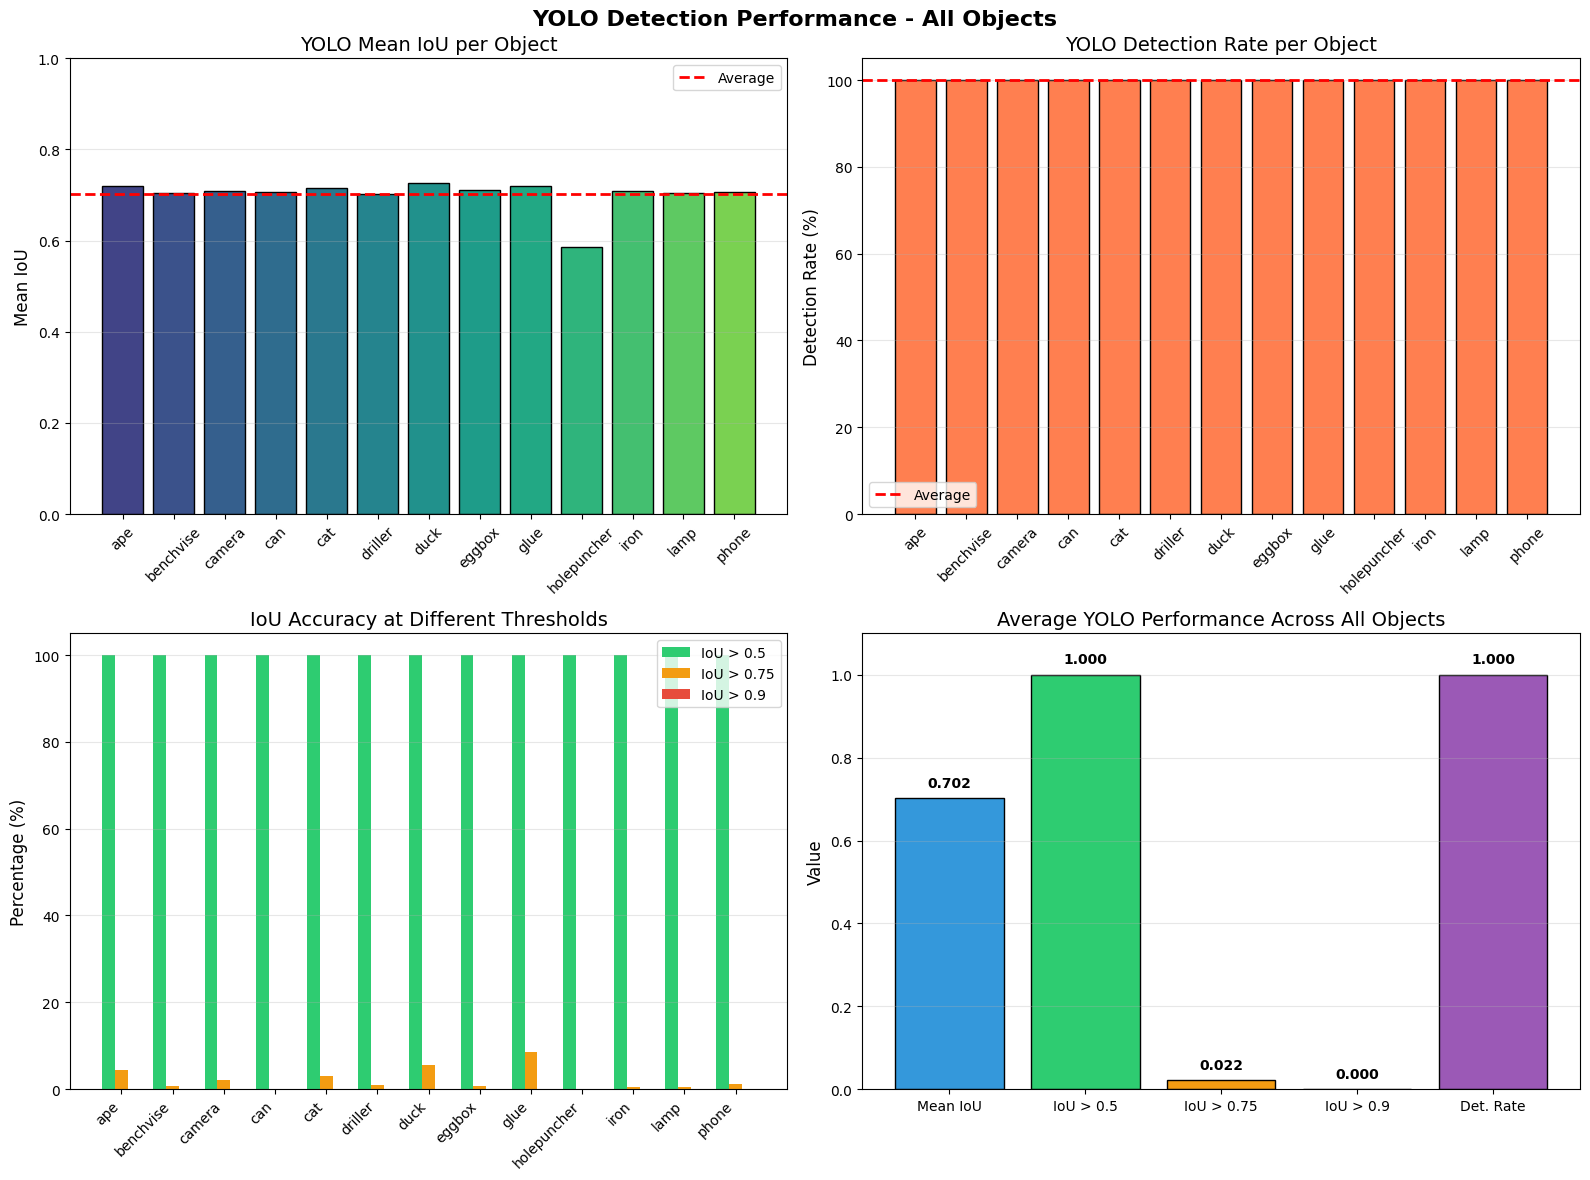

In [63]:
# ==============================================================================
# YOLO VISUALIZATION
# ==============================================================================

if yolo_data:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Filter out AVERAGE row for plotting
    df_plot = df_yolo[df_yolo['Object'] != 'AVERAGE']
    objects = df_plot['Object'].tolist()
    
    # Plot 1: Mean IoU per object
    colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(objects)))
    bars1 = axes[0, 0].bar(objects, df_plot['Mean IoU'], color=colors, edgecolor='black')
    axes[0, 0].axhline(y=df_yolo[df_yolo['Object'] == 'AVERAGE']['Mean IoU'].values[0], 
                       color='red', linestyle='--', linewidth=2, label='Average')
    axes[0, 0].set_ylabel('Mean IoU', fontsize=12)
    axes[0, 0].set_title('YOLO Mean IoU per Object', fontsize=14)
    axes[0, 0].tick_params(axis='x', rotation=45)
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3, axis='y')
    axes[0, 0].set_ylim(0, 1.0)
    
    # Plot 2: Detection Rate per object
    bars2 = axes[0, 1].bar(objects, df_plot['Detection Rate (%)'], color='coral', edgecolor='black')
    axes[0, 1].axhline(y=df_yolo[df_yolo['Object'] == 'AVERAGE']['Detection Rate (%)'].values[0], 
                       color='red', linestyle='--', linewidth=2, label='Average')
    axes[0, 1].set_ylabel('Detection Rate (%)', fontsize=12)
    axes[0, 1].set_title('YOLO Detection Rate per Object', fontsize=14)
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3, axis='y')
    axes[0, 1].set_ylim(0, 105)
    
    # Plot 3: IoU Accuracy at different thresholds
    x = np.arange(len(objects))
    width = 0.25
    
    bars3_1 = axes[1, 0].bar(x - width, df_plot['IoU > 0.5 (%)'], width, label='IoU > 0.5', color='#2ecc71')
    bars3_2 = axes[1, 0].bar(x, df_plot['IoU > 0.75 (%)'], width, label='IoU > 0.75', color='#f39c12')
    bars3_3 = axes[1, 0].bar(x + width, df_plot['IoU > 0.9 (%)'], width, label='IoU > 0.9', color='#e74c3c')
    
    axes[1, 0].set_ylabel('Percentage (%)', fontsize=12)
    axes[1, 0].set_title('IoU Accuracy at Different Thresholds', fontsize=14)
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels(objects, rotation=45, ha='right')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    axes[1, 0].set_ylim(0, 105)
    
    # Plot 4: Summary statistics
    avg_metrics = ['Mean IoU', 'IoU > 0.5', 'IoU > 0.75', 'IoU > 0.9', 'Det. Rate']
    avg_values = [
        df_yolo[df_yolo['Object'] == 'AVERAGE']['Mean IoU'].values[0],
        df_yolo[df_yolo['Object'] == 'AVERAGE']['IoU > 0.5 (%)'].values[0] / 100,
        df_yolo[df_yolo['Object'] == 'AVERAGE']['IoU > 0.75 (%)'].values[0] / 100,
        df_yolo[df_yolo['Object'] == 'AVERAGE']['IoU > 0.9 (%)'].values[0] / 100,
        df_yolo[df_yolo['Object'] == 'AVERAGE']['Detection Rate (%)'].values[0] / 100
    ]
    colors_summary = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c', '#9b59b6']
    
    bars4 = axes[1, 1].bar(avg_metrics, avg_values, color=colors_summary, edgecolor='black')
    axes[1, 1].set_ylabel('Value', fontsize=12)
    axes[1, 1].set_title('Average YOLO Performance Across All Objects', fontsize=14)
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    axes[1, 1].set_ylim(0, 1.1)
    
    for bar, val in zip(bars4, avg_values):
        axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                       f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.suptitle('YOLO Detection Performance - All Objects', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

## RGB Pipeline Evaluation - All Objects

In [64]:
# ==============================================================================
# RGB PIPELINE EVALUATION - ALL OBJECTS
# ==============================================================================

from rgb_pipeline.config import LINEMOD_ID_MAP
name_to_id = {v: k for k, v in LINEMOD_ID_MAP.items()}

print("\n" + "=" * 70)
print("RGB Pipeline Evaluation - ALL OBJECTS")
print("=" * 70 + "\n")

rgb_results_all = {}

for obj_name in ALL_OBJECTS:
    checkpoint_path = os.path.join(project_root, cfg_rgb.SAVE_DIR, obj_name, 'best_model.pth')
    
    if not os.path.exists(checkpoint_path):
        print(f"{obj_name}: checkpoint not found, skipping")
        rgb_results_all[obj_name] = None
        continue
    
    print(f"Evaluating RGB on {obj_name}...", end=" ")
    
    try:
        # Load model points for ADD(-S) metric
        obj_id_int = name_to_id.get(obj_name, 1)
        ply_path = os.path.join(DATA_ROOT, 'models', f'obj_{obj_id_int:02d}.ply')
        model_points = load_ply_vertices(ply_path)
        
        # Get object diameter for ADD(-S) threshold
        diameter = OBJECT_DIMENSIONS.get(obj_name, {}).get('diameter', 0.1)
        is_symmetric = obj_name.lower() in SYMMETRIC_OBJECTS
        metric_name = "ADD-S" if is_symmetric else "ADD"
        
        # Create test dataset
        test_dataset = LineMODDataset(
            root_dir=DATA_ROOT,
            object_name=obj_name,
            split='test',
            mode='rgb',
            yolo_model_path=cfg_inference.YOLO_PATH,
            yolo_padding_pct=0.1,
            rgb_size=cfg_rgb.INPUT_SIZE[0]
        )
        
        test_loader = DataLoader(
            test_dataset,
            batch_size=cfg_rgb.BATCH_SIZE,
            shuffle=False,
            num_workers=0,
            collate_fn=linemod_collate_fn
        )
        
        # Load model
        model = RGBPoseEstimator(backbone=cfg_rgb.BACKBONE, pretrained=False)
        model.load_state_dict(torch.load(checkpoint_path, map_location=device, weights_only=False))
        model.to(device)
        model.eval()
        
        # Run evaluation with diameter for threshold
        results = evaluate_rgb_model(
            model=model,
            dataloader=test_loader,
            device=device,
            object_name=obj_name,
            model_points=model_points,
            diameter=diameter
        )
        
        rgb_results_all[obj_name] = results
        print(f"Rot={results['rot_err_mean']:.2f}°, Trans={results['trans_err_mean']:.2f}cm, {metric_name}={results.get('add_success', 0):.1f}%")
        
        # Clean up to free memory
        del model, test_dataset, test_loader
        torch.cuda.empty_cache() if torch.cuda.is_available() else None
        
    except Exception as e:
        print(f"ERROR: {e}")
        rgb_results_all[obj_name] = None

print("\n" + "=" * 70)
print("RGB Evaluation Complete")
print("=" * 70)


RGB Pipeline Evaluation - ALL OBJECTS

Evaluating RGB on ape... LineMODDataset (rgb): ape/test - 248 frames
Rot=5.68°, Trans=12.81cm, ADD=0.0%
Evaluating RGB on benchvise... LineMODDataset (rgb): benchvise/test - 243 frames
Rot=7.48°, Trans=16.04cm, ADD=0.8%
Evaluating RGB on camera... LineMODDataset (rgb): camera/test - 241 frames
Rot=4.62°, Trans=12.46cm, ADD=0.0%
Evaluating RGB on can... LineMODDataset (rgb): can/test - 240 frames
Rot=5.36°, Trans=12.68cm, ADD=0.8%
Evaluating RGB on cat... LineMODDataset (rgb): cat/test - 236 frames
Rot=6.98°, Trans=13.86cm, ADD=0.0%
Evaluating RGB on driller... LineMODDataset (rgb): driller/test - 238 frames
Rot=5.95°, Trans=14.63cm, ADD=1.3%
Evaluating RGB on duck... LineMODDataset (rgb): duck/test - 251 frames
Rot=5.01°, Trans=12.09cm, ADD=0.0%
Evaluating RGB on eggbox... LineMODDataset (rgb): eggbox/test - 251 frames
Rot=5.24°, Trans=13.20cm, ADD=0.4%
Evaluating RGB on glue... LineMODDataset (rgb): glue/test - 244 frames
Rot=10.71°, Trans=19.08

In [65]:
# ==============================================================================
# RGB RESULTS SUMMARY TABLE
# ==============================================================================

rgb_data = []
for obj_name, results in rgb_results_all.items():
    if results is not None:
        metric_name = results.get('metric_name', 'ADD')
        rgb_data.append({
            'Object': obj_name,
            'Rot Mean (°)': results['rot_err_mean'],
            'Trans Mean (cm)': results['trans_err_mean'],
            'ADD(-S) (m)': results.get('add_mean', 0),
            'Metric': metric_name,
            'ADD(-S) (%)': results.get('add_success', 0),
            'Threshold (m)': results.get('add_threshold', 0),
        })

if rgb_data:
    df_rgb = pd.DataFrame(rgb_data)
    
    # Calculate averages
    avg_row = {
        'Object': 'AVERAGE',
        'Rot Mean (°)': df_rgb['Rot Mean (°)'].mean(),
        'Trans Mean (cm)': df_rgb['Trans Mean (cm)'].mean(),
        'ADD(-S) (m)': df_rgb['ADD(-S) (m)'].mean(),
        'Metric': '-',
        'ADD(-S) (%)': df_rgb['ADD(-S) (%)'].mean(),
        'Threshold (m)': df_rgb['Threshold (m)'].mean(),
    }
    df_rgb = pd.concat([df_rgb, pd.DataFrame([avg_row])], ignore_index=True)
    
    print("\n" + "=" * 110)
    print("RGB PIPELINE RESULTS - ALL OBJECTS")
    print("Note: ADD-S used for symmetric objects (eggbox, glue), ADD for others")
    print("Success threshold: ADD(-S) < 10% of object diameter")
    print("=" * 110)
    
    # Display main metrics
    display_cols = ['Object', 'Rot Mean (°)', 'Trans Mean (cm)', 'ADD(-S) (m)', 'Metric', 'ADD(-S) (%)', 'Threshold (m)']
    print(df_rgb[display_cols].to_string(index=False, float_format=lambda x: f'{x:.4f}' if isinstance(x, float) else str(x)))
    print("=" * 110)
else:
    print("No RGB results available. Train models first.")


RGB PIPELINE RESULTS - ALL OBJECTS
Note: ADD-S used for symmetric objects (eggbox, glue), ADD for others
Success threshold: ADD(-S) < 10% of object diameter
     Object  Rot Mean (°)  Trans Mean (cm)  ADD(-S) (m) Metric  ADD(-S) (%)  Threshold (m)
        ape      5.677855         12.80576       0.1282    ADD       0.0000         0.0102
  benchvise     7.4826455        16.040108       0.1611    ADD       0.8230         0.0248
     camera      4.624211        12.464019       0.1248    ADD       0.0000         0.0172
        can       5.35686        12.680129       0.1273    ADD       0.8333         0.0201
        cat      6.984438        13.861072       0.1391    ADD       0.0000         0.0155
    driller      5.950062        14.629436       0.1463    ADD       1.2605         0.0261
       duck     5.0140567        12.092124       0.1212    ADD       0.0000         0.0109
     eggbox      5.239179        13.203621       0.1321    ADD       0.3984         0.0165
       glue    10.71176

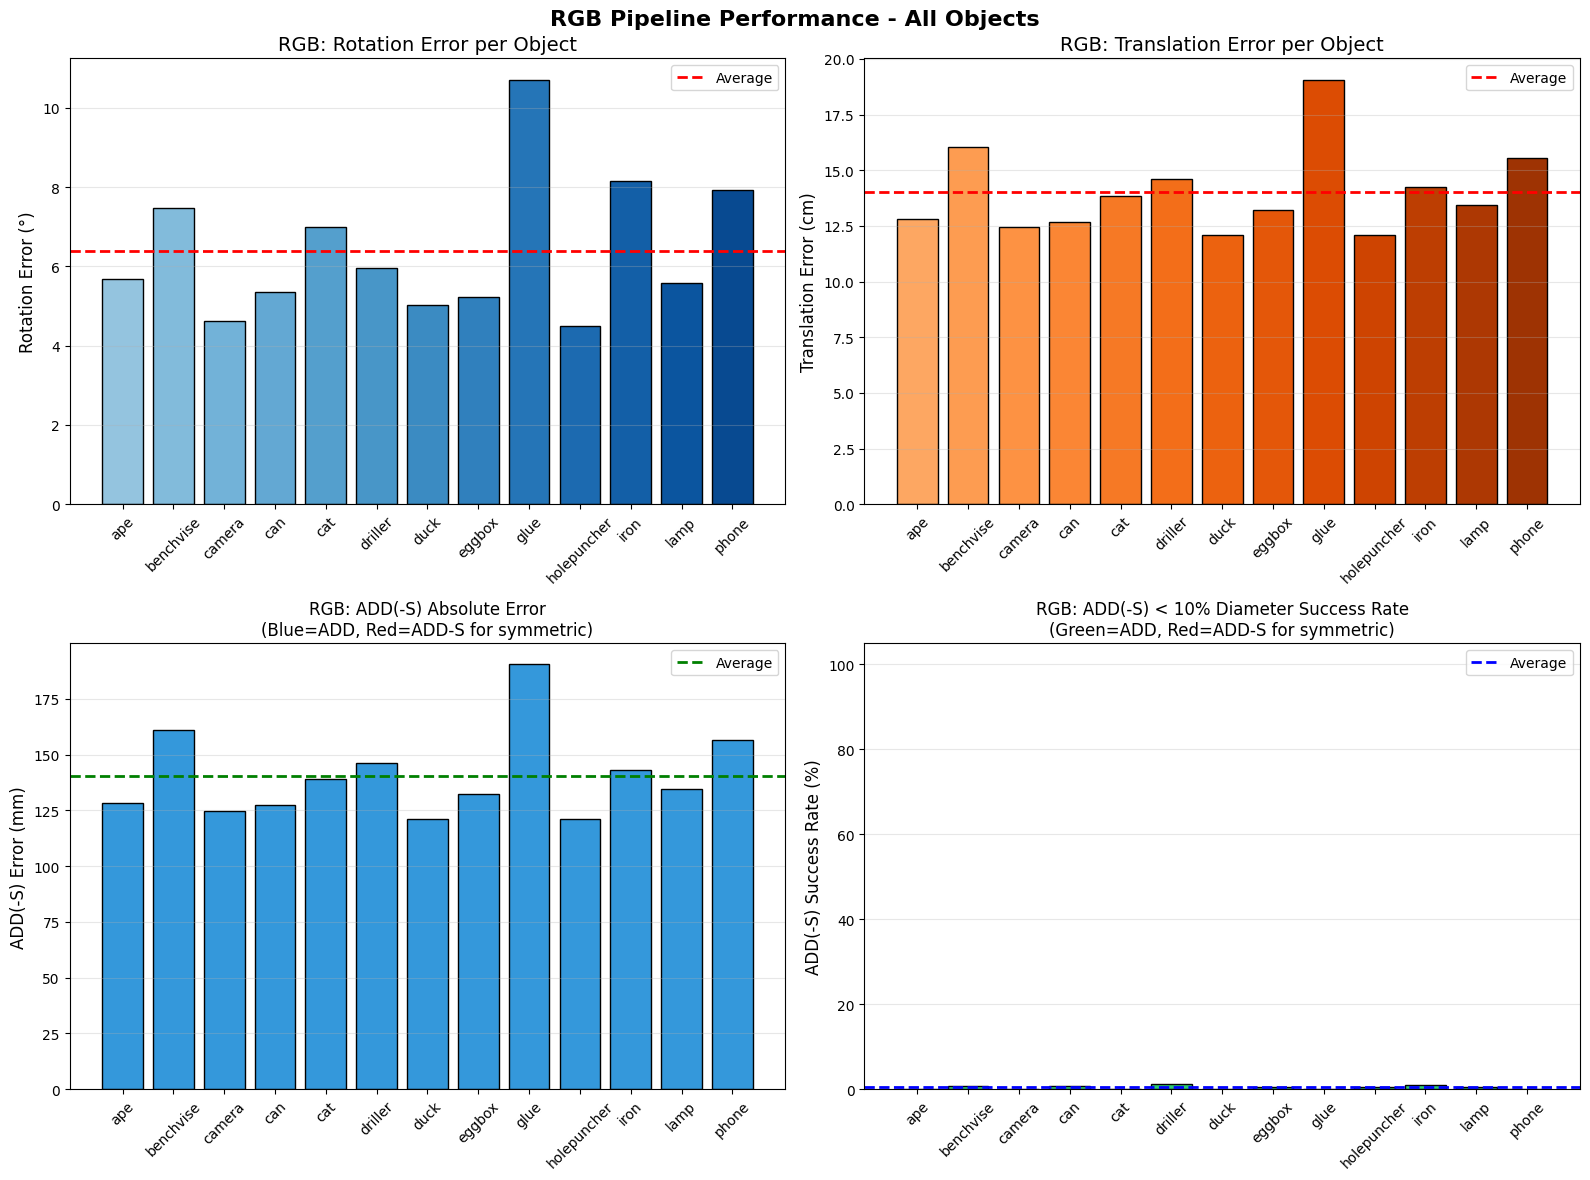

In [66]:
# ==============================================================================
# RGB VISUALIZATION
# ==============================================================================

if rgb_data:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    df_plot = df_rgb[df_rgb['Object'] != 'AVERAGE']
    objects = df_plot['Object'].tolist()
    
    # Plot 1: Rotation Error
    colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(objects)))
    bars1 = axes[0, 0].bar(objects, df_plot['Rot Mean (°)'], color=colors, edgecolor='black')
    axes[0, 0].axhline(y=df_rgb[df_rgb['Object'] == 'AVERAGE']['Rot Mean (°)'].values[0], 
                       color='red', linestyle='--', linewidth=2, label='Average')
    axes[0, 0].set_ylabel('Rotation Error (°)', fontsize=12)
    axes[0, 0].set_title('RGB: Rotation Error per Object', fontsize=14)
    axes[0, 0].tick_params(axis='x', rotation=45)
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3, axis='y')
    
    # Plot 2: Translation Error
    colors = plt.cm.Oranges(np.linspace(0.4, 0.9, len(objects)))
    bars2 = axes[0, 1].bar(objects, df_plot['Trans Mean (cm)'], color=colors, edgecolor='black')
    axes[0, 1].axhline(y=df_rgb[df_rgb['Object'] == 'AVERAGE']['Trans Mean (cm)'].values[0], 
                       color='red', linestyle='--', linewidth=2, label='Average')
    axes[0, 1].set_ylabel('Translation Error (cm)', fontsize=12)
    axes[0, 1].set_title('RGB: Translation Error per Object', fontsize=14)
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3, axis='y')
    
    # Plot 3: ADD(-S) Absolute Value (in mm for better readability)
    colors = []
    for obj in objects:
        if obj in SYMMETRIC_OBJECTS:
            colors.append('#e74c3c')  # Red for ADD-S (symmetric)
        else:
            colors.append('#3498db')  # Blue for ADD (non-symmetric)
    
    add_values_mm = df_plot['ADD(-S) (m)'] * 1000  # Convert to mm
    bars3 = axes[1, 0].bar(objects, add_values_mm, color=colors, edgecolor='black')
    axes[1, 0].axhline(y=df_rgb[df_rgb['Object'] == 'AVERAGE']['ADD(-S) (m)'].values[0] * 1000, 
                       color='green', linestyle='--', linewidth=2, label='Average')
    axes[1, 0].set_ylabel('ADD(-S) Error (mm)', fontsize=12)
    axes[1, 0].set_title('RGB: ADD(-S) Absolute Error\n(Blue=ADD, Red=ADD-S for symmetric)', fontsize=12)
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    
    # Plot 4: ADD(-S) Success Rate with metric type indication
    colors = []
    for obj in objects:
        if obj in SYMMETRIC_OBJECTS:
            colors.append('#e74c3c')  # Red for ADD-S (symmetric)
        else:
            colors.append('#2ecc71')  # Green for ADD (non-symmetric)
    
    bars4 = axes[1, 1].bar(objects, df_plot['ADD(-S) (%)'], color=colors, edgecolor='black')
    axes[1, 1].axhline(y=df_rgb[df_rgb['Object'] == 'AVERAGE']['ADD(-S) (%)'].values[0], 
                       color='blue', linestyle='--', linewidth=2, label='Average')
    axes[1, 1].set_ylabel('ADD(-S) Success Rate (%)', fontsize=12)
    axes[1, 1].set_title('RGB: ADD(-S) < 10% Diameter Success Rate\n(Green=ADD, Red=ADD-S for symmetric)', fontsize=12)
    axes[1, 1].tick_params(axis='x', rotation=45)
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    axes[1, 1].set_ylim(0, 105)
    
    plt.suptitle('RGB Pipeline Performance - All Objects', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

## RGBD Pipeline Evaluation - All Objects

In [67]:
# ==============================================================================
# RGBD PIPELINE EVALUATION - ALL OBJECTS, ALL MODELS
# ==============================================================================

from rgb_pipeline.config import LINEMOD_ID_MAP as LINEMOD_ID_MAP_RGBD
name_to_id_rgbd = {v: k for k, v in LINEMOD_ID_MAP_RGBD.items()}

print("\n" + "=" * 70)
print("RGBD Pipeline Evaluation - ALL OBJECTS, ALL MODELS")
print("ADD(-S) < 10% diameter threshold applied")
print("=" * 70 + "\n")

available_models = list_models()
print(f"Available RGBD models: {available_models}\n")

rgbd_results_all = {model_name: {} for model_name in available_models}

for model_name in available_models:
    print(f"\n--- Evaluating {model_name.upper()} ---")
    
    for obj_name in ALL_OBJECTS:
        obj_idx = OBJ_MAP.get(obj_name.lower(), 0)
        
        checkpoint_path = os.path.join(
            project_root,
            'trained_checkpoints_rgbd',
            model_name,
            obj_name,
            'best_model.pth'
        )
        
        if not os.path.exists(checkpoint_path):
            print(f"  {obj_name}: checkpoint not found, skipping")
            rgbd_results_all[model_name][obj_name] = None
            continue
        
        print(f"  Evaluating on {obj_name}...", end=" ")
        
        try:
            # Load model points for ADD(-S) metric
            obj_id_int = name_to_id_rgbd.get(obj_name, 1)
            ply_path = os.path.join(DATA_ROOT, 'models', f'obj_{obj_id_int:02d}.ply')
            model_points_np = load_ply_vertices(ply_path)
            model_points_torch = torch.from_numpy(model_points_np).float().to(device)
            
            # Get object diameter for ADD(-S) threshold
            diameter = OBJECT_DIMENSIONS.get(obj_name, {}).get('diameter', 0.1)
            is_symmetric = obj_name.lower() in SYMMETRIC_OBJECTS
            metric_name = "ADD-S" if is_symmetric else "ADD"
            
            # Model kwargs
            num_points = 1024
            model_kwargs = {'num_points': num_points, 'num_obj': 13}
            if 'iterative' in model_name:
                model_kwargs['num_iter'] = 2
            if model_name in ['pvn3d', 'ffb6d']:
                model_kwargs['num_kp'] = 8
            
            # Create model
            model = create_model(model_name, **model_kwargs)
            
            # Load checkpoint
            checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
            if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
                state_dict = checkpoint['model_state_dict']
            else:
                state_dict = checkpoint
            
            # Handle key prefix mismatch
            model_keys = set(model.state_dict().keys())
            sample_model_key = next(iter(model_keys))
            sample_ckpt_key = next(iter(state_dict.keys()))
            
            if sample_model_key.startswith('network.') and not sample_ckpt_key.startswith('network.'):
                state_dict = {f'network.{k}': v for k, v in state_dict.items()}
            
            model.load_state_dict(state_dict)
            model.to(device)
            model.eval()
            
            # Create test dataset
            test_dataset = LineMODDataset(
                root_dir=DATA_ROOT,
                object_name=obj_name,
                split='test',
                mode='rgbd',
                num_points=num_points,
                yolo_model_path=cfg_inference.YOLO_PATH,
                yolo_padding_pct=0.1
            )
            
            test_loader = DataLoader(
                test_dataset,
                batch_size=8,
                shuffle=False,
                num_workers=0,
                collate_fn=rgbd_collate_fn
            )
            
            # Run evaluation with ADD(-S) and 10% diameter threshold
            results = evaluate_rgbd_model_with_add(
                model=model,
                dataloader=test_loader,
                device=device,
                obj_idx=obj_idx,
                object_name=obj_name,
                model_points_torch=model_points_torch,
                diameter=diameter,
                model_name=model_name
            )
            rgbd_results_all[model_name][obj_name] = results
            
            print(f"Rot={results['rot_err_mean']:.2f}°, Trans={results['trans_err_mean']:.2f}cm, {metric_name}={results['add_success']:.1f}%")
            
            # Clean up
            del model, test_dataset, test_loader, model_points_torch
            torch.cuda.empty_cache() if torch.cuda.is_available() else None
            
        except Exception as e:
            print(f"ERROR: {e}")
            import traceback
            traceback.print_exc()
            rgbd_results_all[model_name][obj_name] = None

print("\n" + "=" * 70)
print("RGBD Evaluation Complete")
print("=" * 70)


RGBD Pipeline Evaluation - ALL OBJECTS, ALL MODELS
ADD(-S) < 10% diameter threshold applied

Available RGBD models: ['residual_learning', 'densefusion_iterative', 'pvn3d', 'ffb6d']


--- Evaluating RESIDUAL_LEARNING ---
  Evaluating on ape... LineMODDataset (rgbd): ape/test - 248 frames
Rot=4.02°, Trans=0.33cm, ADD=97.6%
  Evaluating on benchvise... LineMODDataset (rgbd): benchvise/test - 243 frames
Rot=4.39°, Trans=0.59cm, ADD=99.6%
  Evaluating on camera... LineMODDataset (rgbd): camera/test - 241 frames
Rot=3.93°, Trans=0.51cm, ADD=98.8%
  Evaluating on can... LineMODDataset (rgbd): can/test - 240 frames
Rot=4.13°, Trans=0.52cm, ADD=99.6%
  Evaluating on cat... LineMODDataset (rgbd): cat/test - 236 frames
Rot=3.46°, Trans=0.36cm, ADD=99.6%
  Evaluating on driller... LineMODDataset (rgbd): driller/test - 238 frames
Rot=4.18°, Trans=0.94cm, ADD=97.5%
  Evaluating on duck... LineMODDataset (rgbd): duck/test - 251 frames
Rot=4.55°, Trans=0.35cm, ADD=99.6%
  Evaluating on eggbox... Line

In [68]:
# ==============================================================================
# RGBD RESULTS SUMMARY TABLES
# ==============================================================================

for model_name in available_models:
    rgbd_data = []
    for obj_name, results in rgbd_results_all[model_name].items():
        if results is not None:
            rgbd_data.append({
                'Object': obj_name,
                'Rot Mean (°)': results['rot_err_mean'],
                'Trans Mean (cm)': results['trans_err_mean'],
                'ADD(-S) (m)': results.get('add_mean', 0),
                'Metric': results.get('metric_name', 'ADD'),
                'ADD(-S) (%)': results.get('add_success', 0),
                'Threshold (m)': results.get('add_threshold', 0),
            })
    
    if rgbd_data:
        df_rgbd = pd.DataFrame(rgbd_data)
        
        # Calculate averages
        avg_row = {
            'Object': 'AVERAGE',
            'Rot Mean (°)': df_rgbd['Rot Mean (°)'].mean(),
            'Trans Mean (cm)': df_rgbd['Trans Mean (cm)'].mean(),
            'ADD(-S) (m)': df_rgbd['ADD(-S) (m)'].mean(),
            'Metric': '-',
            'ADD(-S) (%)': df_rgbd['ADD(-S) (%)'].mean(),
            'Threshold (m)': df_rgbd['Threshold (m)'].mean(),
        }
        df_rgbd = pd.concat([df_rgbd, pd.DataFrame([avg_row])], ignore_index=True)
        
        print("\n" + "=" * 110)
        print(f"RGBD PIPELINE RESULTS - {model_name.upper()}")
        print("Note: ADD-S for symmetric (eggbox, glue), ADD for others. Threshold = 10% diameter")
        print("=" * 110)
        display_cols = ['Object', 'Rot Mean (°)', 'Trans Mean (cm)', 'ADD(-S) (m)', 'Metric', 'ADD(-S) (%)', 'Threshold (m)']
        print(df_rgbd[display_cols].to_string(index=False, float_format=lambda x: f'{x:.4f}' if isinstance(x, float) else str(x)))
        print("=" * 110)


RGBD PIPELINE RESULTS - RESIDUAL_LEARNING
Note: ADD-S for symmetric (eggbox, glue), ADD for others. Threshold = 10% diameter
     Object  Rot Mean (°)  Trans Mean (cm)  ADD(-S) (m) Metric  ADD(-S) (%)  Threshold (m)
        ape        4.0220           0.3324       0.0040    ADD      97.5806         0.0102
  benchvise        4.3939           0.5851       0.0074    ADD      99.5885         0.0248
     camera        3.9327           0.5070       0.0062    ADD      98.7552         0.0172
        can        4.1281           0.5175       0.0067    ADD      99.5833         0.0201
        cat        3.4585           0.3583       0.0043    ADD      99.5763         0.0155
    driller        4.1786           0.9403       0.0105    ADD      97.4790         0.0261
       duck        4.5533           0.3485       0.0044    ADD      99.6016         0.0109
     eggbox        4.2200           0.4975       0.0061    ADD      99.6016         0.0165
       glue        4.0412           0.3859       0.0047

In [69]:
# ==============================================================================
# RGBD MODEL COMPARISON - AVERAGE ACROSS ALL OBJECTS
# ==============================================================================

model_averages = []

for model_name in available_models:
    valid_results = [r for r in rgbd_results_all[model_name].values() if r is not None]
    
    if valid_results:
        model_averages.append({
            'Model': model_name,
            'Rot Mean (°)': np.mean([r['rot_err_mean'] for r in valid_results]),
            'Trans Mean (cm)': np.mean([r['trans_err_mean'] for r in valid_results]),
            'ADD(-S) (m)': np.mean([r.get('add_mean', 0) for r in valid_results]),
            'ADD(-S) (%)': np.mean([r.get('add_success', 0) for r in valid_results]),
            'Num Objects': len(valid_results)
        })

if model_averages:
    df_model_avg = pd.DataFrame(model_averages)
    
    print("\n" + "=" * 100)
    print("RGBD MODEL COMPARISON - AVERAGE ACROSS ALL OBJECTS")
    print("ADD(-S) Success = ADD(-S) < 10% of object diameter")
    print("=" * 100)
    print(df_model_avg.to_string(index=False, float_format=lambda x: f'{x:.4f}' if isinstance(x, float) else str(x)))
    print("=" * 100)
    
    # Find best model by ADD(-S) success rate
    best_idx = df_model_avg['ADD(-S) (%)'].idxmax()
    best_model = df_model_avg.loc[best_idx, 'Model']
    print(f"\n** Best Model (by ADD(-S) success rate): {best_model}")


RGBD MODEL COMPARISON - AVERAGE ACROSS ALL OBJECTS
ADD(-S) Success = ADD(-S) < 10% of object diameter
                Model  Rot Mean (°)  Trans Mean (cm)  ADD(-S) (m)  ADD(-S) (%)  Num Objects
    residual_learning        4.1946           0.5786       0.0070      98.8036           13
densefusion_iterative       13.7087           1.7861       0.0216      62.4990           13
                pvn3d        5.5276           1.8211       0.0190      62.6469           13
                ffb6d        5.1981           4.9275       0.0499       9.5324           13

** Best Model (by ADD(-S) success rate): residual_learning


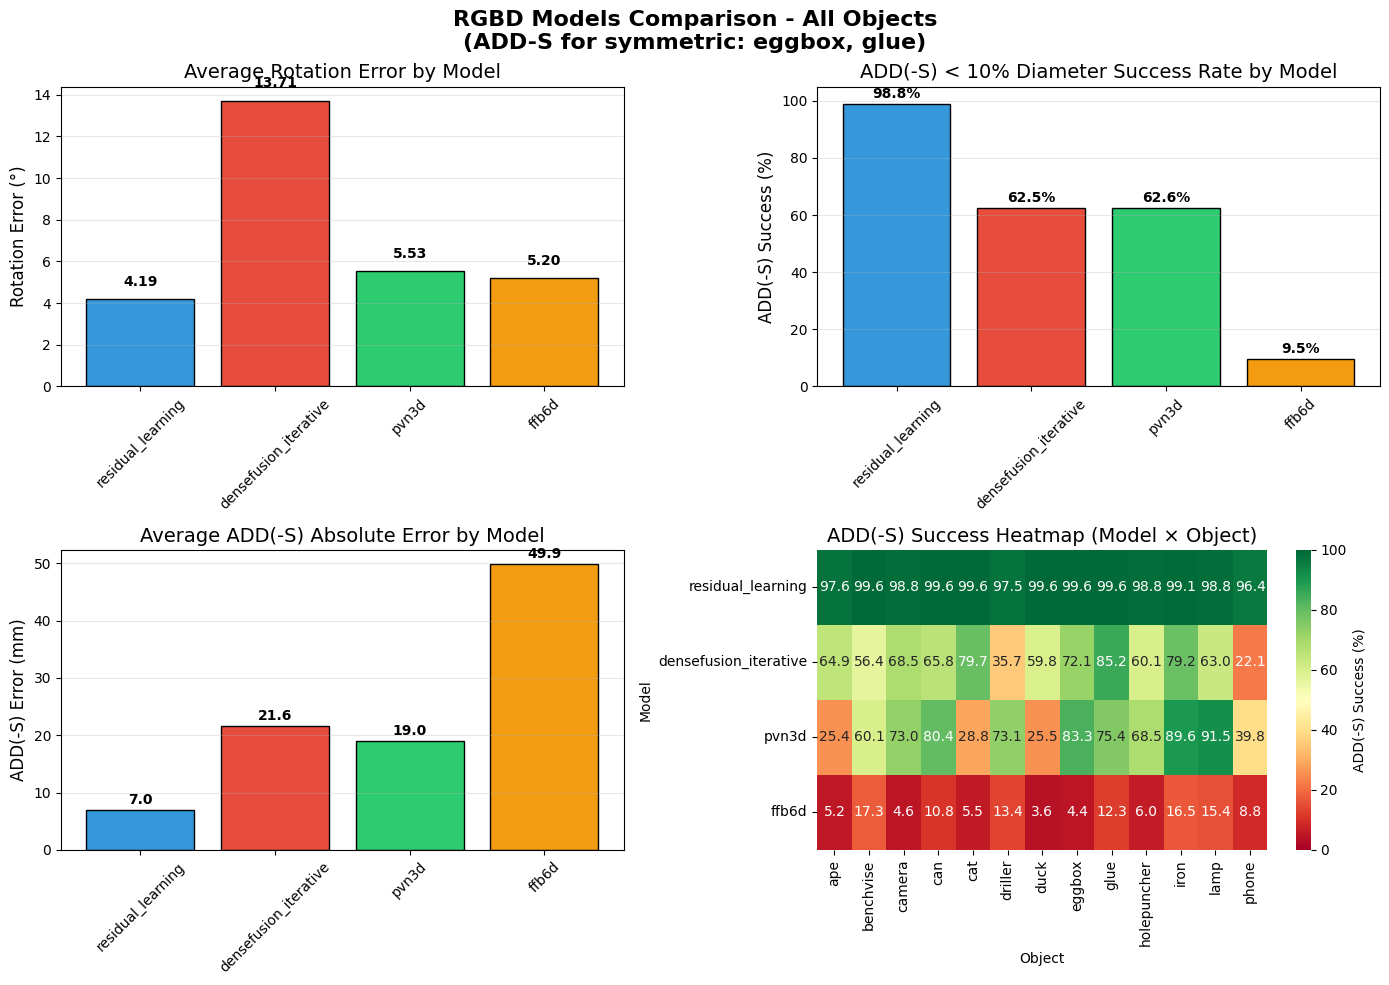

In [70]:
# ==============================================================================
# RGBD VISUALIZATION - MODEL COMPARISON
# ==============================================================================

if model_averages:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    models = df_model_avg['Model'].tolist()
    
    # Plot 1: Rotation Error Comparison
    colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']
    bars1 = axes[0, 0].bar(models, df_model_avg['Rot Mean (°)'], color=colors[:len(models)], edgecolor='black')
    axes[0, 0].set_ylabel('Rotation Error (°)', fontsize=12)
    axes[0, 0].set_title('Average Rotation Error by Model', fontsize=14)
    axes[0, 0].tick_params(axis='x', rotation=45)
    axes[0, 0].grid(True, alpha=0.3, axis='y')
    for bar, val in zip(bars1, df_model_avg['Rot Mean (°)']):
        axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                       f'{val:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Plot 2: ADD(-S) Success Rate Comparison
    bars2 = axes[0, 1].bar(models, df_model_avg['ADD(-S) (%)'], color=colors[:len(models)], edgecolor='black')
    axes[0, 1].set_ylabel('ADD(-S) Success (%)', fontsize=12)
    axes[0, 1].set_title('ADD(-S) < 10% Diameter Success Rate by Model', fontsize=14)
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].grid(True, alpha=0.3, axis='y')
    axes[0, 1].set_ylim(0, 105)
    for bar, val in zip(bars2, df_model_avg['ADD(-S) (%)']):
        axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                       f'{val:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Plot 3: ADD(-S) Absolute Error Comparison (in mm)
    bars3 = axes[1, 0].bar(models, df_model_avg['ADD(-S) (m)'] * 1000, color=colors[:len(models)], edgecolor='black')
    axes[1, 0].set_ylabel('ADD(-S) Error (mm)', fontsize=12)
    axes[1, 0].set_title('Average ADD(-S) Absolute Error by Model', fontsize=14)
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    for bar, val in zip(bars3, df_model_avg['ADD(-S) (m)'] * 1000):
        axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                       f'{val:.1f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Plot 4: Heatmap of ADD(-S) success rate per object
    heatmap_data = []
    for model_name in available_models:
        row = []
        for obj_name in ALL_OBJECTS:
            res = rgbd_results_all[model_name].get(obj_name)
            row.append(res.get('add_success', 0) if res else np.nan)
        heatmap_data.append(row)
    
    heatmap_df = pd.DataFrame(heatmap_data, index=available_models, columns=ALL_OBJECTS)
    
    sns.heatmap(heatmap_df, ax=axes[1, 1], annot=True, fmt='.1f', cmap='RdYlGn', 
                cbar_kws={'label': 'ADD(-S) Success (%)'}, vmin=0, vmax=100)
    axes[1, 1].set_title('ADD(-S) Success Heatmap (Model × Object)', fontsize=14)
    axes[1, 1].set_xlabel('Object')
    axes[1, 1].set_ylabel('Model')
    
    plt.suptitle('RGBD Models Comparison - All Objects\n(ADD-S for symmetric: eggbox, glue)', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

## Overall Summary

In [71]:
# ==============================================================================
# OVERALL SUMMARY
# ==============================================================================

print("\n" + "=" * 80)
print("EVALUATION SUMMARY - ALL OBJECTS")
print("=" * 80)

# YOLO Summary
if yolo_data:
    yolo_avg = df_yolo[df_yolo['Object'] == 'AVERAGE'].iloc[0]
    print(f"\n[YOLO DETECTION]")
    print(f"   Average Mean IoU: {yolo_avg['Mean IoU']:.4f}")
    print(f"   Average Detection Rate: {yolo_avg['Detection Rate (%)']:.1f}%")
    print(f"   IoU > 0.75: {yolo_avg['IoU > 0.75 (%)']:.1f}%")

# RGB Summary
if rgb_data:
    rgb_avg = df_rgb[df_rgb['Object'] == 'AVERAGE'].iloc[0]
    print(f"\n[RGB PIPELINE]")
    print(f"   Average Rotation Error: {rgb_avg['Rot Mean (°)']:.2f}°")
    print(f"   Average Translation Error: {rgb_avg['Trans Mean (cm)']:.2f} cm")
    print(f"   ADD(-S) Absolute Error: {rgb_avg['ADD(-S) (m)'] * 1000:.2f} mm")
    print(f"   ADD(-S) Success Rate: {rgb_avg['ADD(-S) (%)']:.1f}%")

# RGBD Summary
if model_averages:
    print(f"\n[RGBD PIPELINES]")
    for _, row in df_model_avg.iterrows():
        print(f"\n   {row['Model'].upper()}:")
        print(f"      Rotation Error: {row['Rot Mean (°)']:.2f}°")
        print(f"      Translation Error: {row['Trans Mean (cm)']:.2f} cm")
        print(f"      ADD(-S) Absolute Error: {row['ADD(-S) (m)'] * 1000:.2f} mm")
        print(f"      ADD(-S) Success: {row['ADD(-S) (%)']:.1f}%")
        print(f"      Objects Evaluated: {int(row['Num Objects'])}/{len(ALL_OBJECTS)}")

print("\n" + "=" * 80)
print("Evaluation Complete!")
print(f"\nMetric notes:")
print(f"  - ADD-S used for symmetric objects: {', '.join(SYMMETRIC_OBJECTS) if SYMMETRIC_OBJECTS else 'none'}")
print(f"  - ADD used for all other objects")
print(f"  - Success threshold: ADD(-S) < 10% of object diameter")
print("=" * 80)


EVALUATION SUMMARY - ALL OBJECTS

[YOLO DETECTION]
   Average Mean IoU: 0.7015
   Average Detection Rate: 100.0%
   IoU > 0.75: 2.2%

[RGB PIPELINE]
   Average Rotation Error: 6.40°
   Average Translation Error: 14.01 cm
   ADD(-S) Absolute Error: 140.44 mm
   ADD(-S) Success Rate: 0.4%

[RGBD PIPELINES]

   RESIDUAL_LEARNING:
      Rotation Error: 4.19°
      Translation Error: 0.58 cm
      ADD(-S) Absolute Error: 6.97 mm
      ADD(-S) Success: 98.8%
      Objects Evaluated: 13/13

   DENSEFUSION_ITERATIVE:
      Rotation Error: 13.71°
      Translation Error: 1.79 cm
      ADD(-S) Absolute Error: 21.58 mm
      ADD(-S) Success: 62.5%
      Objects Evaluated: 13/13

   PVN3D:
      Rotation Error: 5.53°
      Translation Error: 1.82 cm
      ADD(-S) Absolute Error: 19.03 mm
      ADD(-S) Success: 62.6%
      Objects Evaluated: 13/13

   FFB6D:
      Rotation Error: 5.20°
      Translation Error: 4.93 cm
      ADD(-S) Absolute Error: 49.86 mm
      ADD(-S) Success: 9.5%
      Objects

In [72]:
# ==============================================================================
# EXPORT RESULTS TO CSV (Optional)
# ==============================================================================

EXPORT_CSV = False  # Set to True to export results

if EXPORT_CSV:
    results_dir = os.path.join(project_root, 'logs', 'evaluation_results')
    os.makedirs(results_dir, exist_ok=True)
    
    if yolo_data:
        df_yolo.to_csv(os.path.join(results_dir, 'yolo_all_objects.csv'), index=False)
        print(f"[OK] YOLO results saved to {results_dir}/yolo_all_objects.csv")
    
    if rgb_data:
        df_rgb.to_csv(os.path.join(results_dir, 'rgb_all_objects.csv'), index=False)
        print(f"[OK] RGB results saved to {results_dir}/rgb_all_objects.csv")
        print(f"     Note: 'Metric' column indicates ADD or ADD-S, 'Threshold (m)' is 10% of diameter")
    
    for model_name in available_models:
        rgbd_data = []
        for obj_name, results in rgbd_results_all[model_name].items():
            if results is not None:
                rgbd_data.append({'Object': obj_name, **results})
        if rgbd_data:
            df = pd.DataFrame(rgbd_data)
            df.to_csv(os.path.join(results_dir, f'rgbd_{model_name}_all_objects.csv'), index=False)
            print(f"[OK] RGBD {model_name} results saved")
    
    if model_averages:
        df_model_avg.to_csv(os.path.join(results_dir, 'rgbd_model_comparison.csv'), index=False)
        print(f"[OK] Model comparison saved to {results_dir}/rgbd_model_comparison.csv")
else:
    print("Set EXPORT_CSV = True to export results to CSV files.")
    print("\nNote on metrics:")
    print(f"  - ADD-S (symmetric): {SYMMETRIC_OBJECTS}")
    print(f"  - ADD (non-symmetric): all other objects")
    print(f"  - Success threshold: ADD(-S) < 10% of object diameter")

Set EXPORT_CSV = True to export results to CSV files.

Note on metrics:
  - ADD-S (symmetric): []
  - ADD (non-symmetric): all other objects
  - Success threshold: ADD(-S) < 10% of object diameter
